## Force  Balance along the horizontal axis

This code uses a 2D slice of a 3D thermomechanical subduction model and estimates the horizontal forces caused by the deviatoric stress (net force), the gravitational potential energy (GPE) and the shear stresses (shear force) acting on the base of the lithosphere. In a plain-strain scenario, the shear force balances the GPE and net forces, but in a 3D strain scenario this is not the case.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from scipy import integrate
import scipy.interpolate as inter
import warnings
warnings.filterwarnings("ignore")

## Specify the directory with the input files (data_forceBalance folder)

In [23]:
ddr= "./data_forceBalance/"

### Compensation depth where shear measurements were performed

In [ ]:
comp_depth=-200.0 #km

In [24]:
models= ["/0_deg/","/85_deg/","/NoArc/","/2D_arc/","/2D_arcN/"]
labels = ["0° Ribbon","85° Ribbon","No Ribbon", "2D_Ribbon","2D_NoRibbon"]
d_typp = ["Pre_full.csv","Post_full.csv"]
colors = ["red","darkorange","black","blue","cyan"]

### Function to create paper plot

In [32]:
def get_stress_GPE_shearV2(ddr,model,file_seeds,comp_depth = -200.0,OP= False , SP =False, OP_SP=False, x1=None,x2=None,x1P=None,x2P=None):
    #Pre_collision
    ALL_pre = pd.read_csv(ddr+'/'+model+'/'+file_seeds[0])
    #Post_collision
    ALL_post = pd.read_csv(ddr+'/'+model+'/'+file_seeds[1])
    
    ##### Detect SP and OP at the surface
    

    if model == "/2D_arc/" or model == "/2D_arcN/":
        is_2d = True
    else:
        is_2d = False

    #Crop grid to compensation depth
    #Pre_collision
    indx_comp_depth=np.where(ALL_pre["Points_1"] >= comp_depth)[0]
    #indx_comp_depth, len(indx_comp_depth)
    
    #Post_collision
    indx_comp_depthP=np.where(ALL_post["Points_1"] >= comp_depth)[0]
    #indx_comp_depthP, len(indx_comp_depthP)

    #Pre_collision
    regX,regY = np.unique(ALL_pre["Points_0"][indx_comp_depth]), np.unique(ALL_pre["Points_1"][indx_comp_depth])
    #Post_collision
    regXp,regYp = np.unique(ALL_post["Points_0"][indx_comp_depthP]), np.unique(ALL_post["Points_1"][indx_comp_depthP])

    #Creating regular grid
    #Pre_collision
    X,Y = np.meshgrid (regX,regY[::-1])
    #Post_collision
    Xp,Yp = np.meshgrid (regXp,regYp[::-1])

    # For pre-collision
    #Net stress variable - nearest
    Txx_yy = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["Txx-Tyy"][indx_comp_depth],
                         (X,Y), method='linear', fill_value=np.nan, rescale=True)
    #Pressure variable
    pressure_pre = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["pressureField"][indx_comp_depth],
                         (X,Y), method='linear', fill_value=np.nan, rescale=True)
    #Horizontal deviatoric stress variable
    txx = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["projStressTensor_0"][indx_comp_depth],
                         (X,Y), method='linear', fill_value=np.nan, rescale=True)
    
    if is_2d == False:
        #Vertical deviatoric stress variable
        tyy = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["projStressTensor_4"][indx_comp_depth],
                             (X,Y), method='linear', fill_value=np.nan, rescale=True)
        #Shear deviatoric stress variable
        txy = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["projStressTensor_1"][indx_comp_depth],
                             (X,Y), method='linear', fill_value=np.nan, rescale=True)
    else:
        #Vertical deviatoric stress variable
        tyy = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["projStressTensor_1"][indx_comp_depth],
                             (X,Y), method='linear', fill_value=np.nan, rescale=True)
        #Shear deviatoric stress variable
        txy = inter.griddata((ALL_pre["Points_0"][indx_comp_depth],ALL_pre["Points_1"][indx_comp_depth]), ALL_pre["projStressTensor_2"][indx_comp_depth],
                             (X,Y), method='linear', fill_value=np.nan, rescale=True)

    # For post-collision
    #Net stress variable - nearest
    Txx_yyP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["Txx-Tyy"][indx_comp_depthP],
                         (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
    #Pressure variable
    pressure_post = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["pressureField"][indx_comp_depthP],
                         (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
    #Horizontal stress variable
    txxP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["projStressTensor_0"][indx_comp_depthP],
                         (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
    
    if is_2d == False:
        #Vertical deviatoric stress variable
        tyyP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["projStressTensor_4"][indx_comp_depthP],
                             (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
        #Shear deviatoric stress variable
        txyP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["projStressTensor_1"][indx_comp_depthP],
                             (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
    else:
        #Vertical deviatoric stress variable
        tyyP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["projStressTensor_1"][indx_comp_depthP],
                             (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)
        #Shear deviatoric stress variable
        txyP = inter.griddata((ALL_post["Points_0"][indx_comp_depthP],ALL_post["Points_1"][indx_comp_depthP]), ALL_post["projStressTensor_2"][indx_comp_depthP],
                             (Xp,Yp), method='linear', fill_value=np.nan, rescale=True)

    #Computing full stress tensors
    ref_const1 = pressure_pre[0][0]
    #pre-collision
    pre_SI = -1*pressure_pre - ref_const1
    SXX = pre_SI + txx
    SYY = pre_SI + tyy
    #post-collision
    post_SI = -1*pressure_post -ref_const1
    SXXp = post_SI + txxP
    SYYp = post_SI + tyyP

    #Computing integrals
    #pre-collision
    integral_stress = np.array([1e-12*integrate.trapz((1e6*Txx_yy.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    integral_GPE =  np.array([1e-12*integrate.trapz((SYY.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    integral_xy = np.array(1e-12*integrate.cumtrapz((txy.reshape(len(regY),len(regX)))[-1,:],X[-1,:]*1e3,initial=0))
    integral_SXX = np.array([1e-12*integrate.trapz((SXX.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    integral_SI =  np.array([1e-12*integrate.trapz((pre_SI.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    integral_txx = np.array([1e-12*integrate.trapz((txx.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    integral_tyy = np.array([1e-12*integrate.trapz((tyy.reshape(len(regY),len(regX)))[:,profid],-Y[:,profid]*1e3) for profid in range(0,X.shape[1]) ])
    #post-collision
    integral_stressP = np.array([1e-12*integrate.trapz((1e6*Txx_yyP.reshape(len(regYp),len(regXp)))[:,profid],-Yp[:,profid]*1e3) for profid in range(0,Xp.shape[1]) ])
    integral_GPEP =  np.array([1e-12*integrate.trapz((SYYp.reshape(len(regYp),len(regXp)))[:,profid],-Yp[:,profid]*1e3) for profid in range(0,Xp.shape[1]) ])
    integral_xyP = np.array(1e-12*integrate.cumtrapz((txyP.reshape(len(regYp),len(regXp)))[-1,:],Xp[-1,:]*1e3,initial=0))
    integral_SIp =  np.array([1e-12*integrate.trapz((post_SI.reshape(len(regYp),len(regXp)))[:,profid],-Yp[:,profid]*1e3) for profid in range(0,Xp.shape[1]) ])
    integral_txxP = np.array([1e-12*integrate.trapz((txxP.reshape(len(regYp),len(regXp)))[:,profid],-Yp[:,profid]*1e3) for profid in range(0,Xp.shape[1]) ])
    integral_tyyP = np.array([1e-12*integrate.trapz((tyyP.reshape(len(regYp),len(regXp)))[:,profid],-Yp[:,profid]*1e3) for profid in range(0,Xp.shape[1]) ])

    #Calculating final integrals
    #pre-collision
    net_stress = integral_txx-integral_tyy
    GPE = (integral_SI - integral_SI[1]) + integral_tyy 
    shear_stress = -integral_xy
    #post-collission
    net_stressp = integral_txxP-integral_tyyP
    GPEp = (integral_SIp - integral_SIp[1]) + integral_tyyP
    shear_stressP = -integral_xyP

    #print(x1,x2,x1P,x2P)

    ### Filtering X distance
    if x1 is not None and x2 is not None:
        #print(regX.shape)
        indxs = np.where(np.logical_and(regX >= x1,regX <=x2))[0]

        #print(indxs,net_stress,len(GPE),len(shear_stress))

        regX,net_stress,GPE,shear_stress = (regX[indxs],
         net_stress[indxs],
         GPE[indxs],
         shear_stress[indxs]
        )
        
    if x1P is not None and x2P is not None:
        indxsP = np.where(np.logical_and(regXp >= x1P,regXp <=x2P))[0]

        #print(indxsP)

        regXp,net_stressp,GPEp,shear_stressP = (regXp[indxsP],
         net_stressp[indxsP],
         GPEp[indxsP],
         shear_stressP[indxsP]
        )
    
    return regX,regY,net_stress,GPE,shear_stress,regXp,regYp,net_stressp,GPEp,shear_stressP,Txx_yy ,Txx_yyP,X,Xp,Y,Yp

### Paper plot

/0_deg/
/85_deg/
/NoArc/
/2D_arc/
/2D_arcN/


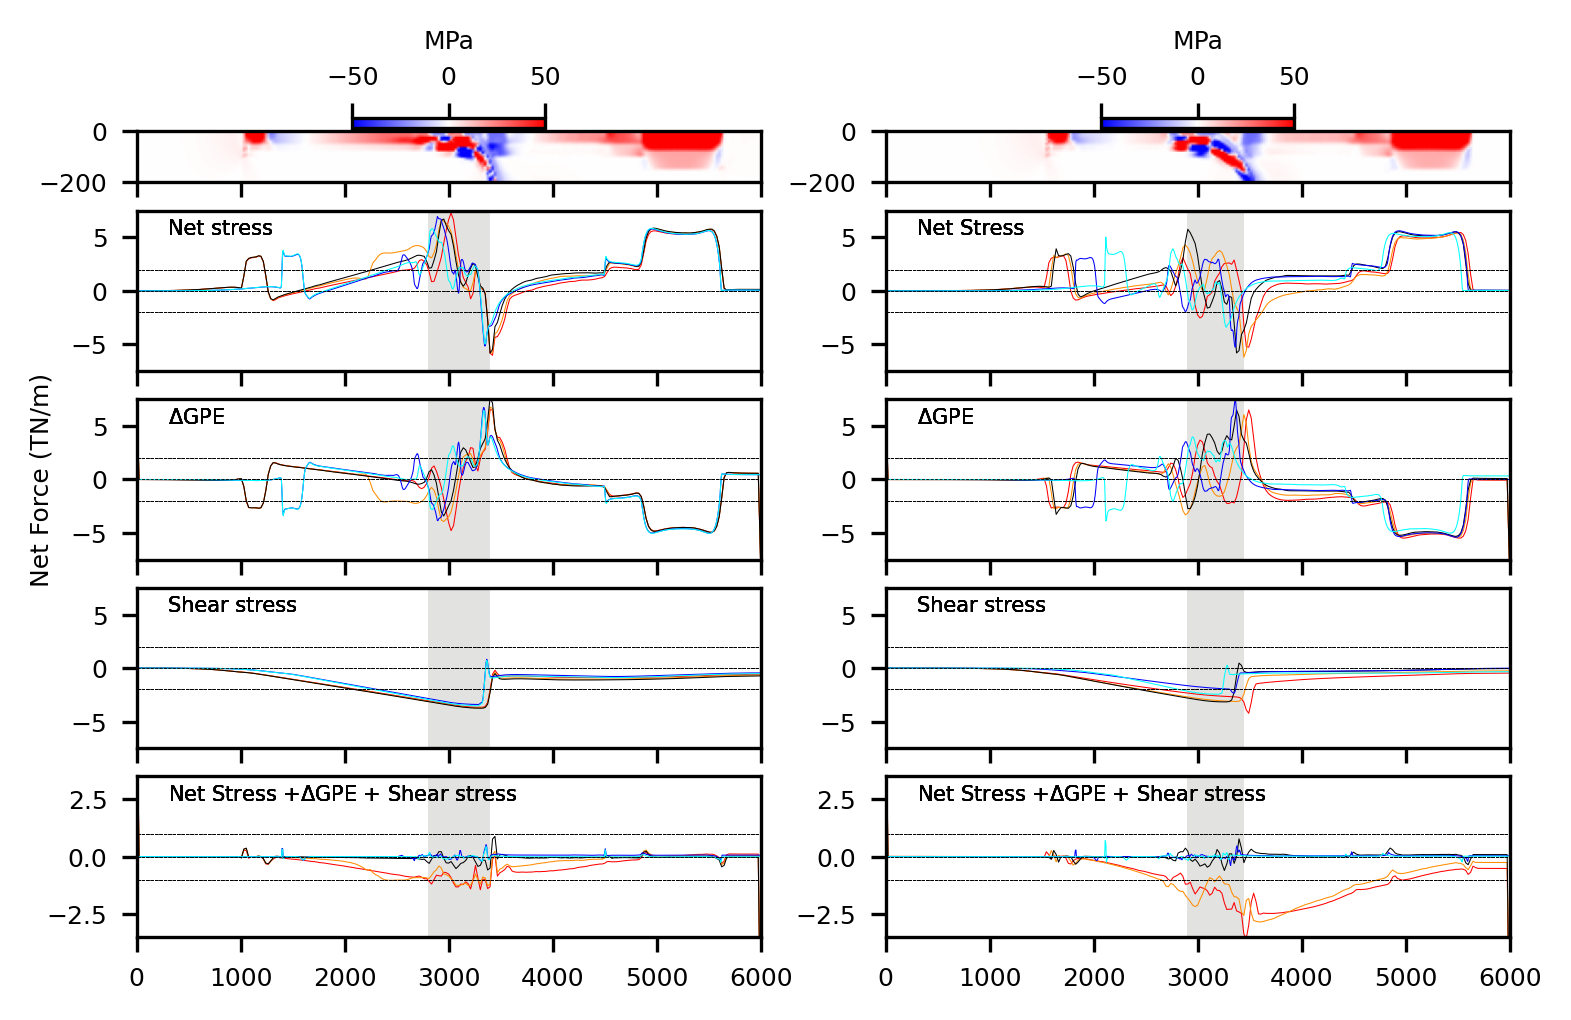

In [33]:
nrows = 5
ncols = 2

xmin = 1000
xmax = 2000

colors = ["red","darkorange","black","blue","cyan"]

fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=((15/2.54), (9/2.54)), sharey=False,sharex=True,dpi=300,gridspec_kw={'height_ratios': [0.8,2,2,2,2]})

i=0

ylimss = (-7.5,7.5)

for model in models:

    print(model)

    ##Get data -  3300,5900,3300,5900
    (regX,regY,net_stress,GPE,shear_stress,
     regXp,regYp,net_stressp,GPEp,shear_stressP, Txx_yy,Txx_yyP,X,Xp,Y,Yp,
    ) =  get_stress_GPE_shearV2(ddr,model,d_typp,comp_depth,x1=0,x2=6000,x1P=0,x2P=6000)#,is_2d)


    if i==0:
        #Slab-plot - Pre Collision
        pcm=axes.flatten()[0].pcolormesh(X, Y, Txx_yy.reshape(len(regY),len(regX)), cmap='bwr', shading='gouraud',
                   #norm=LogNorm(vmin=0.001, vmax=1E2)
                   vmin=-50,vmax=50,
                  )

        axes.flatten()[0].tick_params(axis="both", labelsize=6)
    
        cbar = fig.colorbar(pcm,label='MPa',ax=axes.flatten()[0],location="top", shrink=5)
        cbar.set_label('MPa', fontsize=6)  # Set label size here
        cbar.ax.tick_params(labelsize=6)    # Set tick label size for color bar

        #cbar.tick_params(labelsize=6)

        #cbar.ax.tick_params(labelsize=10) 
    
        #Slab-plot - Post Collision
        pcm1=axes.flatten()[1].pcolormesh(Xp, Yp, Txx_yyP.reshape(len(regYp),len(regXp)), cmap='bwr', shading='gouraud',
                   #norm=LogNorm(vmin=0.001, vmax=1E2)
                   vmin=-50,vmax=50,
                  )

        axes.flatten()[1].tick_params(axis="both", labelsize=6)
    
        cbar1 = fig.colorbar(pcm1,label='MPa',ax=axes.flatten()[1],location="top", shrink=5)
        cbar1.set_label('MPa', fontsize=6)  # Set label size here
        cbar1.ax.tick_params(labelsize=6)    # Set tick label size for color bar

    
    #plot
    #Net stress
    axes.flatten()[2].plot(regX,net_stress,linewidth=0.25,color = colors[i])  
    #axes.flatten()[2].set_title("Net_stress = {0} TN/m".format(labels()),size=5)  
    axes.flatten()[2].set_ylim(ylimss)#fontsize=8)
    axes.flatten()[2].tick_params(axis="both", labelsize=6)
    #axes.flatten()[2].set_xticks([-50,0,100])
    #axes.flatten()[2].set_xlabel(r'$\tau_{XX}-\tau_{YY}$ (MPa)', fontsize = 4)
    #axes.flatten()[2].set_ylabel("Net Force (TN/m)",fontsize = 6)
    axes.flatten()[2].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[2].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[2].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)

    axes.flatten()[2].text(0.05, 0.95, 'Net stress', fontsize=5, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
         transform=axes.flatten()[2].transAxes,  # Use axis coordinates
         ha='left', va='top')

    axes.flatten()[2].axvspan(2800, 3400, facecolor='#6D6860', alpha=0.04)
    
    #plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ##################
    #GPE stress
    axes.flatten()[4].plot(regX,GPE,linewidth=0.25,color = colors[i])  
    #axes.flatten()[4].set_title("GPE = {0} TN/m".format(),size=5)  
    axes.flatten()[4].set_ylim(ylimss)#fontsize=8)
    axes.flatten()[4].set_ylabel("Net Force (TN/m)",fontsize = 6)
    #axes.flatten()[4].set_ylabel("Horizontal distance (Km)",fontsize = 6)
    axes.flatten()[4].tick_params(axis="both", labelsize=6)
    axes.flatten()[4].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[4].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[4].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)
    #axes.flatten()[4].set_xticks([-50,0,100])
    axes.flatten()[4].text(0.05, 0.95, r"$\Delta$"+'GPE', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[4].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[4].axvspan(2800, 3400, facecolor='#6D6860', alpha=0.04)
    ##################
    #Shear stress
    axes.flatten()[6].plot(regX[:len(shear_stress)],shear_stress,linewidth=0.25,color = colors[i])  
    #axes.flatten()[6].set_title("Shear_stress = {0} TN/m".format(),size=5)  
    axes.flatten()[6].set_ylim(ylimss)#fontsize=8)
    axes.flatten()[6].tick_params(axis="both", labelsize=6)
    axes.flatten()[6].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[6].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[6].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)
    #axes.flatten()[6].set_xticks([-50,0,100])
    axes.flatten()[6].text(0.05, 0.95, 'Shear stress', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[6].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[6].axvspan(2800, 3400, facecolor='#6D6860', alpha=0.04)

        #Net stress + GPE + Shear
    axes.flatten()[8].plot(regX,shear_stress +net_stress[:len(shear_stress)] + GPE[:len(shear_stress)],linewidth=0.25,color = colors[i])  
    #axes.flatten()[8].set_title("Net_stress = {0} TN/m".format(labels()),size=5)  
    axes.flatten()[8].set_ylim(-3.5,3.5)#fontsize=8)
    axes.flatten()[8].tick_params(axis="both", labelsize=6)
    #axes.flatten()[8].set_xticks([-50,0,100])
    #axes.flatten()[8].set_xlabel(r'$\tau_{XX}-\tau_{YY}$ (MPa)', fontsize = 4)
    #axes.flatten()[8].set_ylabel("Net Force (TN/m)",fontsize = 6)
    axes.flatten()[8].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[8].axhline(y = -1.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[8].axhline(y = 1.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[8].text(0.05, 0.95, 'Net Stress +' + r"$\Delta$"+'GPE +' + ' Shear stress', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[8].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[8].axvspan(2800, 3400, facecolor='#6D6860', alpha=0.04)

   ######################################################################################################################################################################################
    #Net stress
    axes.flatten()[3].plot(regXp,net_stressp,linewidth=0.25,color = colors[i])  
    #axes.flatten()[3].set_title("Net_stress = {0} TN/m".format(),size=5)  
    axes.flatten()[3].set_ylim(ylimss)#fontsize=8)
    #axes.flatten()[3].set_ylabel("Net Force (TN/m)",fontsize = 6)
    axes.flatten()[3].tick_params(axis="both", labelsize=6)
    axes.flatten()[3].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[3].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[3].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)
    #axes.flatten()[3].set_xticks([-50,0,100])
    axes.flatten()[3].text(0.05, 0.95, 'Net Stress', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[3].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[3].axvspan(2900, 3450, facecolor='#6D6860', alpha=0.04)

    #GPE stress
    axes.flatten()[5].plot(regXp,GPEp,linewidth=0.25,color = colors[i])  
    #axes.flatten()[5].set_title("GPE = {0} TN/m".format(),size=5)  
    axes.flatten()[5].set_ylim(ylimss)#fontsize=8)
    axes.flatten()[5].tick_params(axis="both", labelsize=6)
    axes.flatten()[5].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[5].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[5].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[5].text(0.05, 0.95, r"$\Delta$"+'GPE', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[5].transAxes,  # Use axis coordinates
             ha='left', va='top')
    #axes.flatten()[6].set_xticks([-50,0,100])
    axes.flatten()[5].axvspan(2900, 3450, facecolor='#6D6860', alpha=0.04)

    #Shear stress
    axes.flatten()[7].plot(regXp[:len(shear_stressP)],shear_stressP,linewidth=0.25,color = colors[i], label = labels[i])  
    #axes.flatten()[7].set_title("Shear_stress = {0} TN/m".format(),size=5)  
    axes.flatten()[7].set_ylim(ylimss)#fontsize=8)
    axes.flatten()[7].tick_params(axis="both", labelsize=6)
    axes.flatten()[7].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[7].axhline(y = -2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[7].axhline(y = 2.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[7].text(0.05, 0.95, 'Shear stress', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[7].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[7].axvspan(2900, 3450, facecolor='#6D6860', alpha=0.04)
    #Net stress + GPE + Shear
    axes.flatten()[9].plot(regXp[:len(shear_stressP)],shear_stressP +net_stressp[:len(shear_stressP)] + GPEp[:len(shear_stressP)] ,linewidth=0.25,color = colors[i], linestyle = '-',label = labels[i])  
    #axes.flatten()[9].set_title("Net_stress = {0} TN/m".format(labels()),size=5)  
    #axes.flatten()[9].set_ylim(-0.2,0.2)#fontsize=8)
    axes.flatten()[9].set_ylim(-3.5,3.5)#fontsize=8)
    axes.flatten()[9].tick_params(axis="both", labelsize=6)
    #axes.flatten()[9].set_xticks([-50,0,100])
    #axes.flatten()[9].set_xlabel(r'$\tau_{XX}-\tau_{YY}$ (MPa)', fontsize = 4)
    #axes.flatten()[9].set_ylabel("Net Force (TN/m)",fontsize = 6)
    axes.flatten()[9].axhline(y = 0.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[9].axhline(y = -1.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[9].axhline(y = 1.0, color = 'black', linestyle = '--',linewidth=0.2)
    axes.flatten()[9].text(0.05, 0.95, 'Net Stress +' + r"$\Delta$"+'GPE +' + ' Shear stress', fontsize=5, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.0),
             transform=axes.flatten()[9].transAxes,  # Use axis coordinates
             ha='left', va='top')

    axes.flatten()[9].axvspan(2900, 3450, facecolor='#6D6860', alpha=0.04)

    axes.flatten()[4].set_xlabel("Horizontal distance (Km)",fontsize = 6)
    
    i=i+1
